In [20]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import tensorflow as tf
import pandas as pd 
import splitfolders
import numpy as np
import keras
import os
import cv2

from tensorflow.keras import Model
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator

plt.style.use('ggplot')

### **Preprocessing Dataset**

In [3]:
splitfolders.ratio('dataset', output="splitted_data", ratio=(0.8, 0.2))

Copying files: 4485 files [00:00, 10915.74 files/s]


In [4]:
train_datagen = ImageDataGenerator( 
      rescale = 1.0/255.,
      shear_range=0.2,
      zoom_range=0.2,
      horizontal_flip=True,
      fill_mode='nearest'
)

test_datagen  = ImageDataGenerator(rescale = 1.0/255.)

training_set = train_datagen.flow_from_directory(
    'splitted_data/train',
    batch_size=64,
    class_mode='categorical',
    target_size=(224, 224)
)     

test_set = test_datagen.flow_from_directory(
    'splitted_data/val',
    batch_size=20,
    class_mode  = 'categorical',
    target_size = (224, 224)
)

Found 3583 images belonging to 15 classes.
Found 902 images belonging to 15 classes.


### **Membangun Model CNN**

In [31]:
cnn = tf.keras.models.Sequential()
cnn.add(tf.keras.layers.Conv2D(filters=32, kernel_size=7, activation='relu', input_shape=[224, 224, 3]))
cnn.add(tf.keras.layers.MaxPool2D(pool_size=2, strides=2))
cnn.add(tf.keras.layers.Conv2D(filters=32, kernel_size=3, activation='relu'))
cnn.add(tf.keras.layers.MaxPool2D(pool_size=2, strides=2))
cnn.add(tf.keras.layers.Conv2D(filters=32, kernel_size=3, activation='relu'))
cnn.add(tf.keras.layers.MaxPool2D(pool_size=2, strides=2))
cnn.add(tf.keras.layers.Flatten())
cnn.add(tf.keras.layers.Dense(units=500, activation='relu'))
cnn.add(tf.keras.layers.Dense(units=15, activation='sigmoid'))

cnn.compile(
    optimizer = 'adam', 
    loss = 'categorical_crossentropy', 
    metrics = ['accuracy']
)

In [32]:
cnn.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_190 (Conv2D)         (None, 218, 218, 32)      4736      
                                                                 
 max_pooling2d_10 (MaxPoolin  (None, 109, 109, 32)     0         
 g2D)                                                            
                                                                 
 conv2d_191 (Conv2D)         (None, 107, 107, 32)      9248      
                                                                 
 max_pooling2d_11 (MaxPoolin  (None, 53, 53, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_192 (Conv2D)         (None, 51, 51, 32)        9248      
                                                                 
 max_pooling2d_12 (MaxPoolin  (None, 25, 25, 32)      

In [33]:
history = cnn.fit(x=training_set, epochs=15, validation_data=test_set, batch_size=256)

Epoch 1/15
56/56 [==============================] - 30s 518ms/step - loss: 2.6351 - accuracy: 0.1220 - val_loss: 2.4000 - val_accuracy: 0.2373
Epoch 2/15
56/56 [==============================] - 29s 520ms/step - loss: 2.1645 - accuracy: 0.2944 - val_loss: 2.0279 - val_accuracy: 0.3581
Epoch 3/15
56/56 [==============================] - 29s 515ms/step - loss: 1.7467 - accuracy: 0.4362 - val_loss: 1.6322 - val_accuracy: 0.4579
Epoch 4/15
56/56 [==============================] - 29s 518ms/step - loss: 1.4510 - accuracy: 0.5107 - val_loss: 1.4740 - val_accuracy: 0.5155
Epoch 5/15
56/56 [==============================] - 29s 518ms/step - loss: 1.3227 - accuracy: 0.5610 - val_loss: 1.3619 - val_accuracy: 0.5322
Epoch 6/15
56/56 [==============================] - 29s 520ms/step - loss: 1.1409 - accuracy: 0.6073 - val_loss: 1.3191 - val_accuracy: 0.5698
Epoch 7/15
56/56 [==============================] - 29s 513ms/step - loss: 0.9907 - accuracy: 0.6707 - val_loss: 1.2178 - val_accuracy: 0.5820

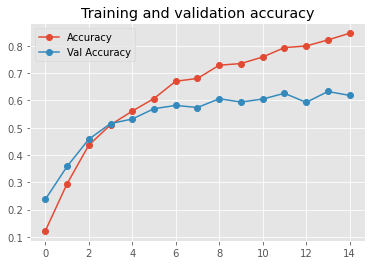

In [35]:
acc = history.history['accuracy' ]
val_acc = history.history['val_accuracy' ]
epochs = range(len(acc)) 

plt.plot(epochs, acc, label="Accuracy", marker='o')
plt.plot(epochs, val_acc, label="Val Accuracy", marker='o')
plt.title('Training and validation accuracy')
plt.legend()
plt.show()

### **Fine-tuned CNN Dengan InceptionV3**

In [ ]:
pre_trained_model = tf.keras.applications.InceptionV3(
    input_shape = (224, 224, 3),
    include_top=False, 
    weights='imagenet'
)

In [10]:
for layer in pre_trained_model.layers:
    layer.trainable = False

last_layer = pre_trained_model.get_layer('mixed7')
last_output = last_layer.output

In [11]:
x = tf.keras.layers.Flatten()(last_output)
x = tf.keras.layers.Dense(512, activation='relu')(x)
x = tf.keras.layers.Dropout(0.2)(x)                  
x = tf.keras.layers.Dense (15, activation='sigmoid')(x)           

model = Model(pre_trained_model.input, x) 

model.compile(
    optimizer = 'adam', 
    loss = 'categorical_crossentropy', 
    metrics = ['accuracy']
)

In [12]:
history = model.fit(
    training_set,
    validation_data=test_set,
    steps_per_epoch=10,
    epochs=8,
    validation_steps=8,
    verbose=2
)

Epoch 1/8
10/10 - 8s - loss: 9.1394 - accuracy: 0.3099 - val_loss: 3.9496 - val_accuracy: 0.4500 - 8s/epoch - 823ms/step
Epoch 2/8
10/10 - 5s - loss: 1.5559 - accuracy: 0.6609 - val_loss: 0.8918 - val_accuracy: 0.7188 - 5s/epoch - 533ms/step
Epoch 3/8
10/10 - 5s - loss: 0.7961 - accuracy: 0.7594 - val_loss: 0.5438 - val_accuracy: 0.8125 - 5s/epoch - 542ms/step
Epoch 4/8
10/10 - 5s - loss: 0.5864 - accuracy: 0.8078 - val_loss: 0.5170 - val_accuracy: 0.8062 - 5s/epoch - 533ms/step
Epoch 5/8
10/10 - 5s - loss: 0.4488 - accuracy: 0.8391 - val_loss: 0.4104 - val_accuracy: 0.8625 - 5s/epoch - 545ms/step
Epoch 6/8
10/10 - 5s - loss: 0.3819 - accuracy: 0.8922 - val_loss: 0.3877 - val_accuracy: 0.8875 - 5s/epoch - 543ms/step
Epoch 7/8
10/10 - 5s - loss: 0.3212 - accuracy: 0.8998 - val_loss: 0.3015 - val_accuracy: 0.8813 - 5s/epoch - 539ms/step
Epoch 8/8
10/10 - 5s - loss: 0.3472 - accuracy: 0.8905 - val_loss: 0.3954 - val_accuracy: 0.8750 - 5s/epoch - 532ms/step


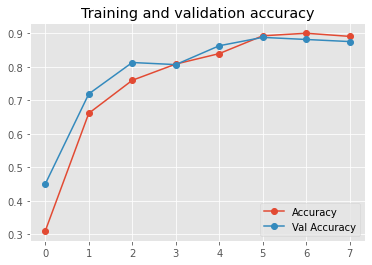

In [30]:
acc = history.history['accuracy' ]
val_acc = history.history['val_accuracy' ]
epochs = range(len(acc)) 

plt.plot(epochs, acc, label="Accuracy", marker='o')
plt.plot(epochs, val_acc, label="Val Accuracy", marker='o')
plt.title('Training and validation accuracy')
plt.legend(loc="lower right")
plt.show()

### **Contoh Prediksi Model**

In [21]:
def predict(path):
    img = mpimg.imread(path)
    imgplot = plt.imshow(img)
    
    img = cv2.imread(path)
    img = cv2.resize(img,(224,224))
    img = np.reshape(img,[1,224,224,3])
    img = img/255.0

    classes = model.predict(img)
    predicted = np.argmax(classes, axis=1)
    
    print(f'Predicted : {predicted} \n')

Predicted : [1] 



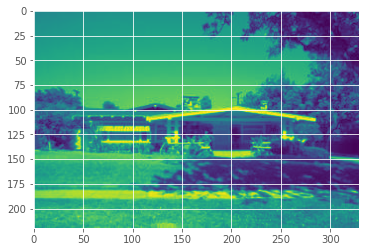

In [26]:
predict('splitted_data/val/01/280.jpg')

Predicted : [7] 



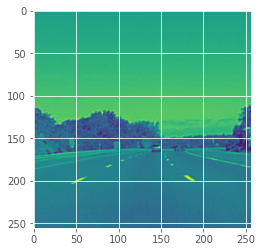

In [25]:
predict('splitted_data/val/07/2008.jpg')

###### 